In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from itertools import cycle
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
label_encoder=LabelEncoder()

In [3]:
df = pd.read_csv('D:\PyCharmProject\InterstateTrafficDataset\Metro_Interstate_Traffic_Volume.csv')

In [4]:
df.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,None,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00
1,4516,None,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00
2,4767,None,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00
3,5026,None,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00
4,4918,None,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48204 non-null  int64  
 1   holiday              48204 non-null  object 
 2   temp                 48204 non-null  float64
 3   rain_1h              48204 non-null  float64
 4   snow_1h              48204 non-null  float64
 5   clouds_all           48204 non-null  int64  
 6   weather_main         48204 non-null  object 
 7   weather_description  48204 non-null  object 
 8   date_time            48204 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
df.isna().sum()

traffic_volume         0
holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
dtype: int64

In [7]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [8]:
df['weather_main'].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [9]:
df['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [10]:
#get a copy of original df to perform analysis
df1=df.copy()

In [11]:
cycol = cycle('bgrcmk')

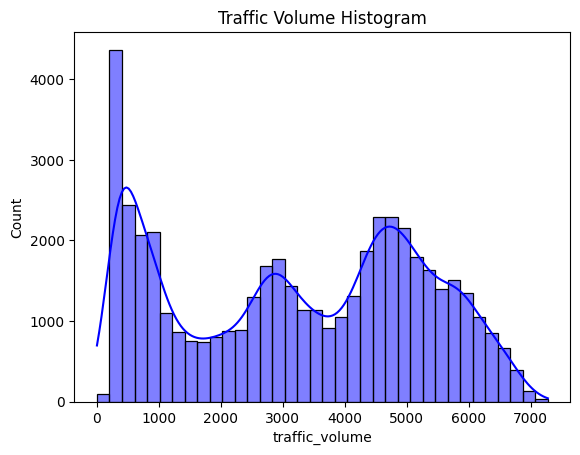

In [12]:
sns.histplot(df1['traffic_volume'], color=next(cycol), kde=True)
plt.title('Traffic Volume Histogram')
plt.show()

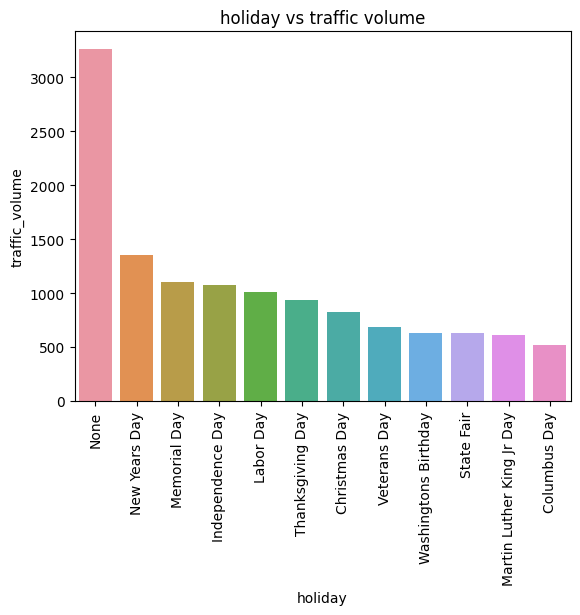

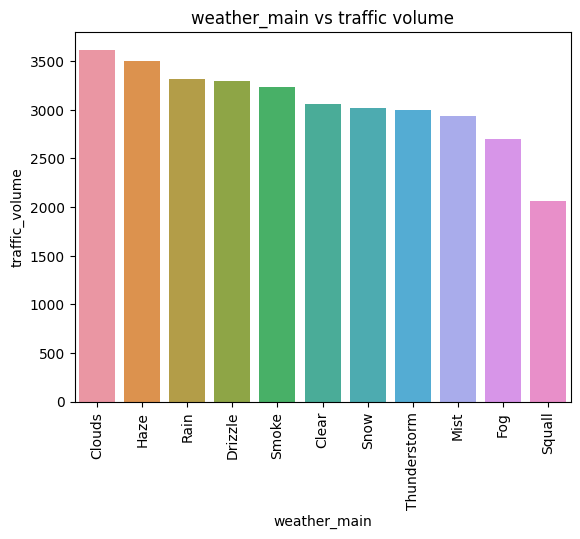

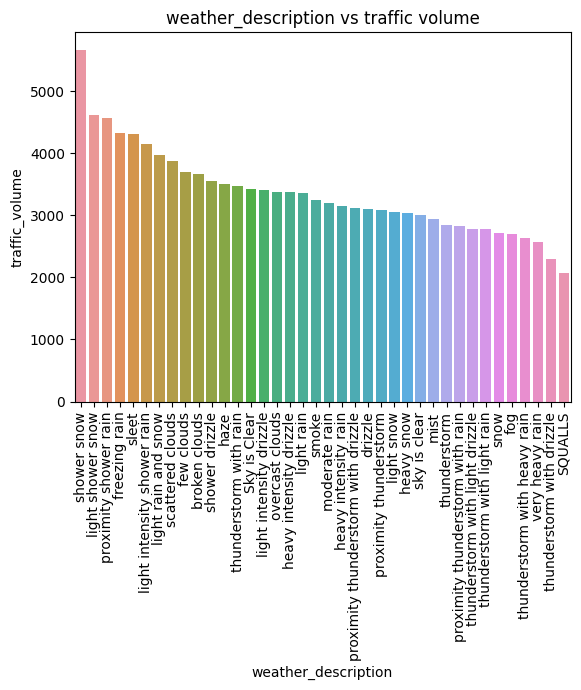

In [13]:
#Average traffic volume
for col in ['holiday','weather_main','weather_description']:
    df_col_grouped=df1.groupby([col])['traffic_volume'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(x=df_col_grouped[col],y=df_col_grouped['traffic_volume'])
    plt.title(f'{col} vs traffic volume')
    plt.xticks(rotation=90)
    plt.show()

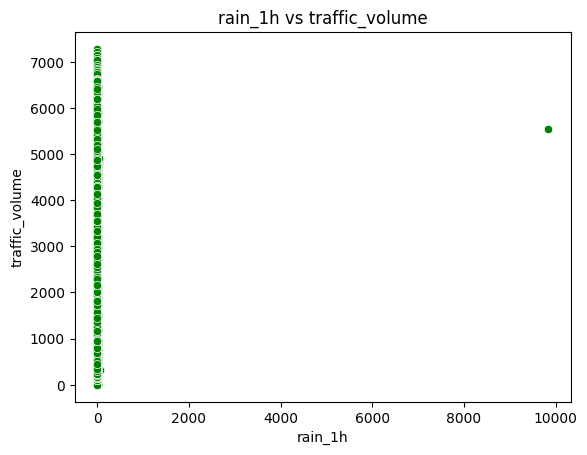

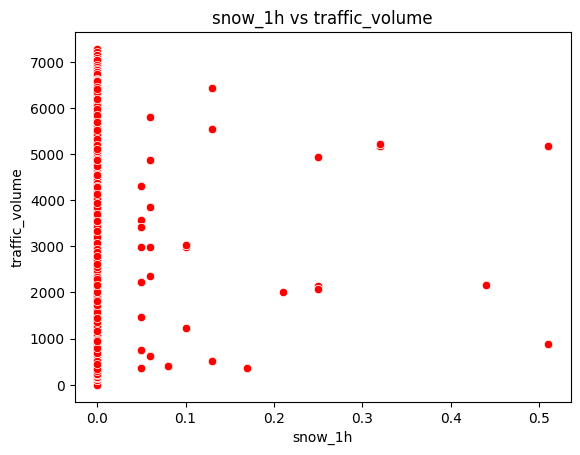

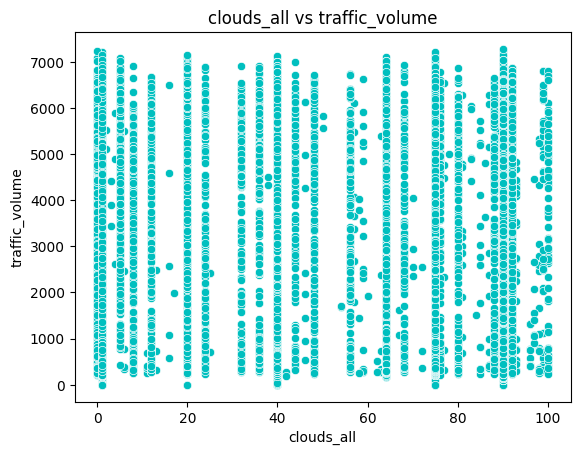

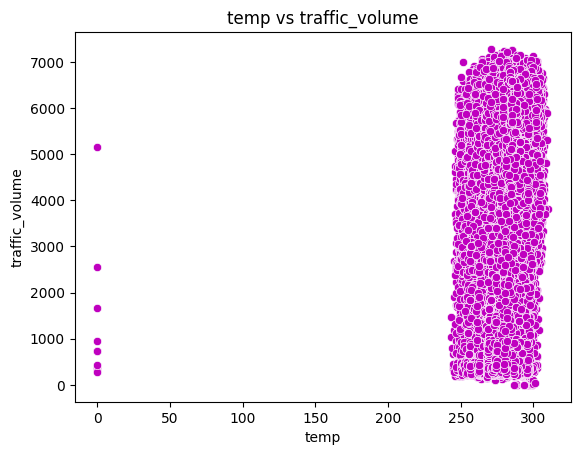

In [14]:
for col in ['rain_1h','snow_1h','clouds_all','temp']:
    sns.scatterplot(x=df[col],y=df1['traffic_volume'], color=next(cycol))
    plt.xlabel(col)
    plt.ylabel('traffic_volume')
    plt.title(f'{col} vs traffic_volume')
    plt.show()

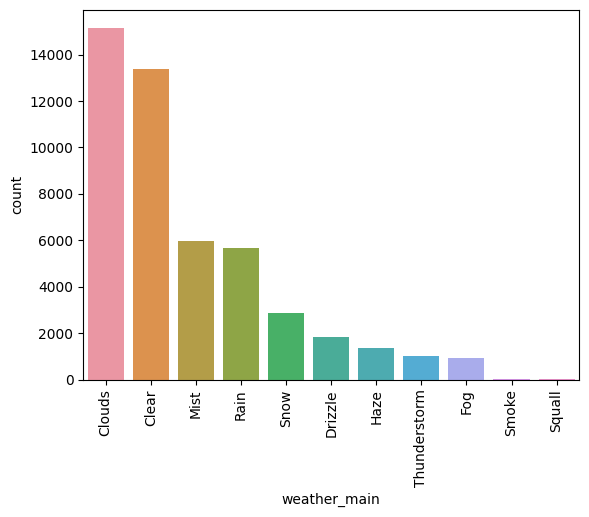

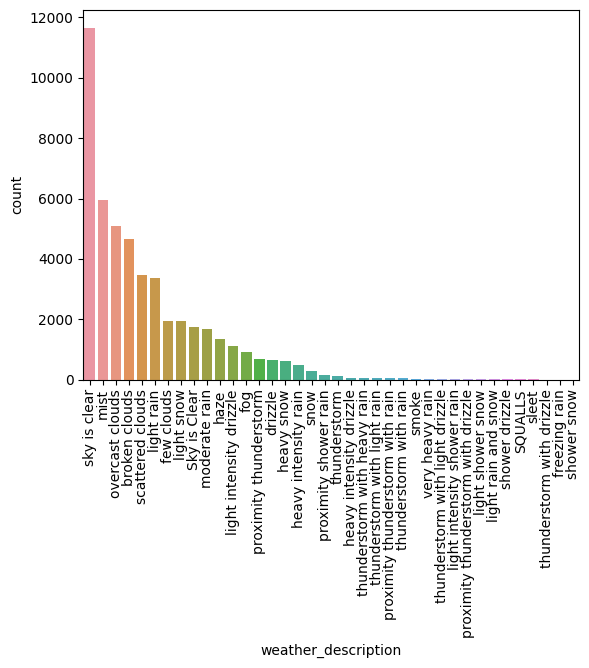

In [15]:
for col in ['weather_main','weather_description']:
    sns.countplot(x=col, data=df1, order = df1[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.show()

In [16]:
dfcat=df1.copy()

In [17]:
dfcat['date_time'] = pd.to_datetime(dfcat['date_time'], format="%d-%m-%Y %H:%M")

In [18]:
for col in dfcat.select_dtypes(include=['object']).columns.tolist():
    dfcat[col]= label_encoder.fit_transform(dfcat[col])

In [19]:
dfcat.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,7,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00
1,4516,7,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00
2,4767,7,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00
3,5026,7,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00
4,4918,7,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00


In [20]:
def prepare_training_sets(df):
    X, y = df.drop(columns = ['traffic_volume']), df[['traffic_volume']].values.reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = prepare_training_sets(dfcat)

In [22]:
model=CatBoostRegressor(iterations=2000,
                        learning_rate=0.02, 
                        loss_function='RMSE',
                        depth=6,
                        task_type="GPU", 
                        devices='0:1')

In [23]:
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose=100)

0:	learn: 1984.3124253	test: 1983.4980694	best: 1983.4980694 (0)	total: 15.5ms	remaining: 31s
100:	learn: 1909.6556828	test: 1909.6768035	best: 1909.6768035 (100)	total: 1.5s	remaining: 28.2s
200:	learn: 1896.8251767	test: 1899.0217087	best: 1899.0217087 (200)	total: 2.93s	remaining: 26.2s
300:	learn: 1888.5307541	test: 1892.6545242	best: 1892.6545242 (300)	total: 4.34s	remaining: 24.5s
400:	learn: 1882.2912031	test: 1887.8089154	best: 1887.7954120 (399)	total: 5.75s	remaining: 22.9s
500:	learn: 1876.4224976	test: 1883.1482126	best: 1883.1482126 (500)	total: 7.23s	remaining: 21.6s
600:	learn: 1871.5612565	test: 1879.1632062	best: 1879.1632062 (600)	total: 8.61s	remaining: 20s
700:	learn: 1867.3070575	test: 1876.1174690	best: 1876.1174690 (700)	total: 10.1s	remaining: 18.6s
800:	learn: 1863.8728066	test: 1873.4387375	best: 1873.4387375 (800)	total: 11.5s	remaining: 17.2s
900:	learn: 1858.9823440	test: 1870.0144751	best: 1870.0144751 (900)	total: 12.9s	remaining: 15.8s
1000:	learn: 1854.

In [24]:
y_pred=model.predict(X_test)
test_rmse=mean_squared_error(y_pred, y_test, squared=False)
print(f"Test RMSE of model 1 is {test_rmse}")

Test RMSE of model 1 is 1852.8309717324971


In [25]:
dfcat_1=dfcat.copy()

In [26]:
#Seperate datetime into day, month, year, hour
dfcat_1['day']=dfcat_1['date_time'].dt.day_name()
dfcat_1['month']=dfcat_1['date_time'].dt.month_name()
dfcat_1['year']=dfcat_1['date_time'].dt.year
dfcat_1['hour']=dfcat_1['date_time'].dt.hour

In [27]:
dfcat_1=dfcat_1.drop(columns=(['date_time']))

In [28]:
for col in dfcat_1.select_dtypes(include=['object']).columns.tolist():
    dfcat_1[col]= label_encoder.fit_transform(dfcat_1[col])

In [29]:
dfcat_1.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,day,month,year,hour
0,5545,7,288.28,0.0,0.0,40,1,24,5,10,2012,9
1,4516,7,289.36,0.0,0.0,75,1,2,5,10,2012,10
2,4767,7,289.58,0.0,0.0,90,1,19,5,10,2012,11
3,5026,7,290.13,0.0,0.0,90,1,19,5,10,2012,12
4,4918,7,291.14,0.0,0.0,75,1,2,5,10,2012,13


In [30]:
X_train_1, X_test_1, y_train_1, y_test_1 = prepare_training_sets(dfcat_1)

In [31]:
model1=CatBoostRegressor(iterations=2000,
                        learning_rate=0.02, 
                        loss_function='RMSE',
                        depth=6,
                        task_type="GPU", 
                        devices='0:1')

In [32]:
model1.fit(X_train_1, y_train_1,
         eval_set=(X_test_1, y_test_1),
         verbose=100)

0:	learn: 1952.7731795	test: 1951.8190121	best: 1951.8190121 (0)	total: 15.3ms	remaining: 30.6s
100:	learn: 685.7230147	test: 680.9155722	best: 680.9155722 (100)	total: 1.61s	remaining: 30.3s
200:	learn: 561.9943009	test: 557.2466185	best: 557.2466185 (200)	total: 3.18s	remaining: 28.4s
300:	learn: 525.1162330	test: 522.8979994	best: 522.8979994 (300)	total: 4.78s	remaining: 27s
400:	learn: 503.7486016	test: 503.2876911	best: 503.2876911 (400)	total: 6.29s	remaining: 25.1s
500:	learn: 488.1140067	test: 489.2911416	best: 489.2911416 (500)	total: 8.28s	remaining: 24.8s
600:	learn: 476.6438437	test: 479.2568917	best: 479.2568917 (600)	total: 10.1s	remaining: 23.4s
700:	learn: 469.0724601	test: 472.7550153	best: 472.7550153 (700)	total: 11.7s	remaining: 21.7s
800:	learn: 463.4004197	test: 467.9673697	best: 467.9673697 (800)	total: 13.4s	remaining: 20s
900:	learn: 459.7757999	test: 464.9760393	best: 464.9760393 (900)	total: 14.9s	remaining: 18.2s
1000:	learn: 456.5494707	test: 462.2339236	b

In [33]:
y_pred_1=model1.predict(X_test_1)
test_rmse_1=mean_squared_error(y_pred_1, y_test_1, squared=False)
print(f"Test RMSE of model 2 is {test_rmse_1}")

Test RMSE of model 2 is 449.8727136982658


In [34]:
explainer = shap.Explainer(model1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


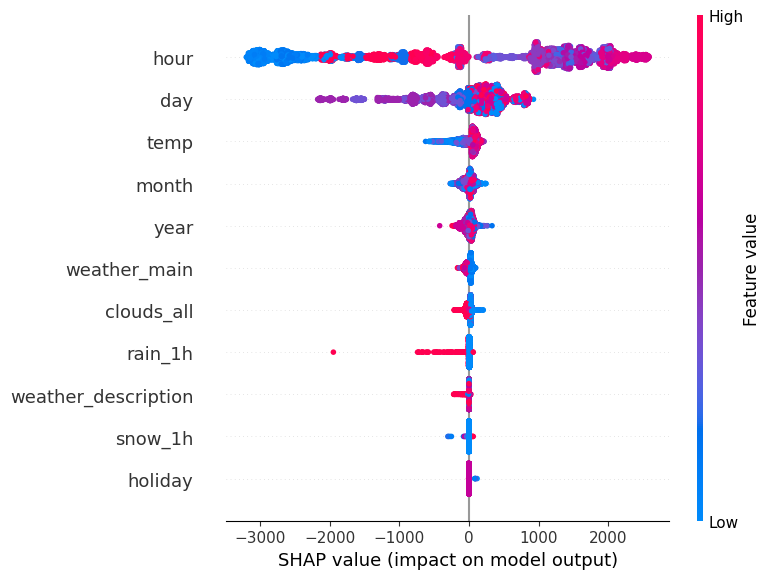

In [35]:
shap_values=explainer(X_test_1)
shap.summary_plot(shap_values,X_test_1)

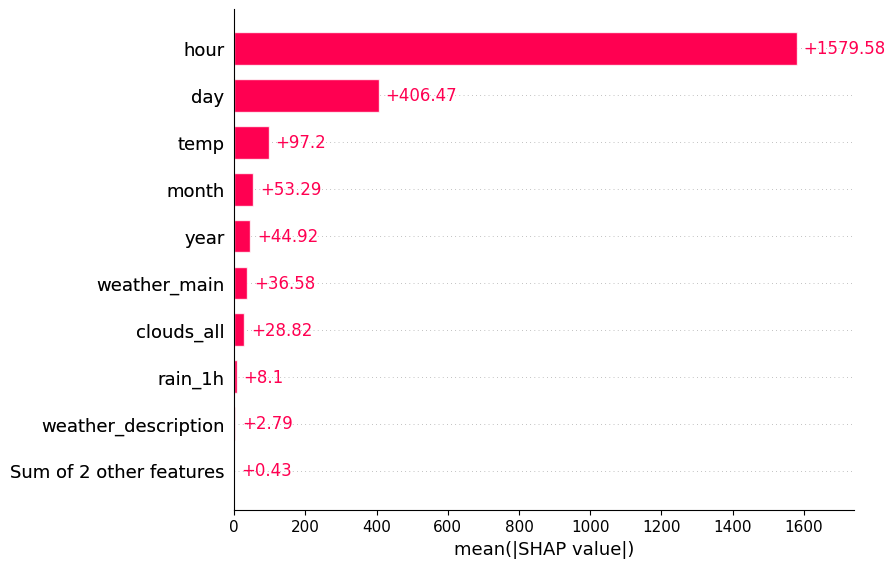

In [36]:
shap.plots.bar(shap_values)

In [37]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = prepare_training_sets(df)

In [38]:
random=np.random.choice(len(X_test_1))
print(f"Viewing choice {random}")
print(X_train_orig.iloc[random])
shap.plots.force(shap_values[random])

Viewing choice 2789
holiday                                   None
temp                                    281.95
rain_1h                                    0.0
snow_1h                                    0.0
clouds_all                                  90
weather_main                           Drizzle
weather_description    heavy intensity drizzle
date_time                     20-05-2017 23:00
Name: 33859, dtype: object


In [ ]:
"""
Seperating datetime into its respective components seemed to greatly increase performance of the model as the specific hour had
the most impact on the traffic volume. 
"""